## Libraries and Dataset

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [18]:
data = pd.read_csv("customer_purchase_data.csv")

## Exploratory Data Analysis

In [19]:
data.head()

,Age,Gender,AnnualIncome,NumberOfPurchases,ProductCategory,TimeSpentOnWebsite,LoyaltyProgram,DiscountsAvailed,PurchaseStatus
0,40,1,66120.267939,8,0,30.568601,0,5,1
1,20,1,23579.773583,4,2,38.240097,0,5,0
2,27,1,127821.306432,11,2,31.633212,1,0,1
3,24,1,137798.623120,19,3,46.167059,0,4,1
4,31,1,99300.964220,19,1,19.823592,0,0,1


In [20]:
data.isnull().sum()

Age                   0
Gender                0
AnnualIncome          0
NumberOfPurchases     0
ProductCategory       0
TimeSpentOnWebsite    0
LoyaltyProgram        0
DiscountsAvailed      0
PurchaseStatus        0
dtype: int64

In [21]:
data.describe()

,Age,Gender,AnnualIncome,NumberOfPurchases,ProductCategory,TimeSpentOnWebsite,LoyaltyProgram,DiscountsAvailed,PurchaseStatus
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,44.298667,0.504667,84249.164338,10.420000,2.012667,30.469040,0.326667,2.555333,0.43200
std,15.537259,0.500145,37629.493078,5.887391,1.428005,16.984392,0.469151,1.705152,0.49552
min,18.000000,0.000000,20001.512518,0.000000,0.000000,1.037023,0.000000,0.000000,0.00000
25%,31.000000,0.000000,53028.979155,5.000000,1.000000,16.156700,0.000000,1.000000,0.00000
50%,45.000000,1.000000,83699.581476,11.000000,2.000000,30.939516,0.000000,3.000000,0.00000
75%,57.000000,1.000000,117167.772858,15.000000,3.000000,44.369863,1.000000,4.000000,1.00000
max,70.000000,1.000000,149785.176481,20.000000,4.000000,59.991105,1.000000,5.000000,1.00000


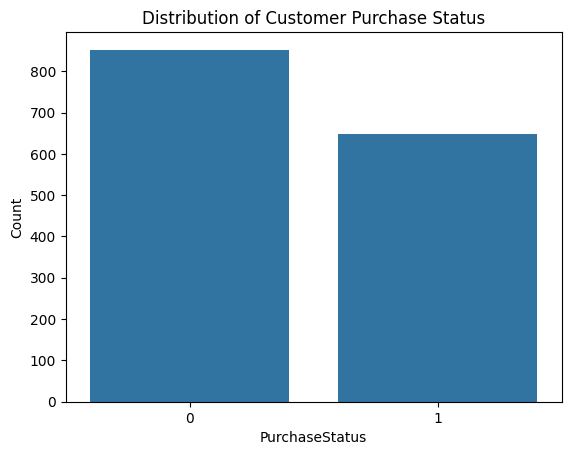

In [22]:
sns.countplot(x = data["PurchaseStatus"], data = data)
plt.title("Distribution of Customer Purchase Status")
plt.ylabel("Count")
plt.show()

## Data Preprocessing and Models

In [23]:
X = data.drop("PurchaseStatus", axis = 1)
y = data["PurchaseStatus"]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Train the Model

In [26]:
from sklearn.model_selection import GridSearchCV

# Paramter grid for each model
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

In [27]:
# Initialize the models
rf = RandomForestClassifier(random_state=42)
svm = SVC(probability=True, random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)
nb = GaussianNB()  # Naive Bayes does not typically need hyperparameter tuning

# Grid search for each model
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1)
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, n_jobs=-1)
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, n_jobs=-1)

# Fit grid search
grid_rf.fit(X_train, y_train)
grid_svm.fit(X_train, y_train)
grid_lr.fit(X_train, y_train)

# The best models
best_rf = grid_rf.best_estimator_
best_svm = grid_svm.best_estimator_
best_lr = grid_lr.best_estimator_

In [28]:
from sklearn.ensemble import StackingClassifier

# Create the stacking classifier with the optimized models
stacked_model = StackingClassifier(
    estimators=[
        ('rf', best_rf),
        ('svm', best_svm),
        ('lr', best_lr),
        ('nb', nb)
    ],
    final_estimator=LogisticRegression()
)

In [29]:
# Train the stacking model
stacked_model.fit(X_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=10,
                                                       min_samples_split=10,
                                                       n_estimators=200,
                                                       random_state=42)),
                               ('svm',
                                SVC(C=100, gamma=0.01, probability=True,
                                    random_state=42)),
                               ('lr',
                                LogisticRegression(C=1, max_iter=1000,
                                                   random_state=42)),
                               ('nb', GaussianNB())],
                   final_estimator=LogisticRegression())

## Evaluate the Model

In [30]:
stacked_pred = stacked_model.predict(X_test)
accuracy = accuracy_score(y_test, stacked_pred)
recall = recall_score(y_test, stacked_pred)
precision = precision_score(y_test, stacked_pred)
F1 = f1_score(y_test, stacked_pred)

print(f'Accuracy of the stacking ensemble model: {accuracy:.2f}')
print(f'Recall of the stacking ensemble model: {recall:.2f}')
print(f'Precision of the stacking ensemble model: {precision:.2f}')
print(f'F1 score of the stacking ensemble model: {F1:.2f}')

Accuracy of the stacking ensemble model: 0.95
Recall of the stacking ensemble model: 0.91
Precision of the stacking ensemble model: 0.97
F1 score of the stacking ensemble model: 0.94
